In [1]:
import argparse
import os
import pathlib
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import tifffile
import torch
import tqdm
from PIL import Image
from rich.pretty import pprint
from stardist.models import StarDist2D
from ultrack import to_tracks_layer, track, tracks_to_zarr
from ultrack.config import MainConfig
from ultrack.imgproc import normalize
from ultrack.utils import estimate_parameters_from_labels, labels_to_contours

# check if in a jupyter notebook

try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(f"Running in notebook: {in_notebook}")

os.environ["OMP_NUM_THREADS"] = "8"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# check gpu
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if not gpu_devices:
    print("No GPU found")
else:
    print("GPU found")


# tensorflow clear gpu memory
def clear_gpu_memory():
    from numba import cuda

    cuda.select_device(0)
    cuda.close()


clear_gpu_memory()

2025-01-06 13:37:26.604079: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-06 13:37:26.604106: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-06 13:37:26.604112: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 13:37:26.640352: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running in notebook: True
GPU found


2025-01-06 13:37:30.013069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-06 13:37:30.099976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-06 13:37:30.104427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
if not in_notebook:
    print("Running as script")
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir_main",
        type=str,
        help="Path to the input directory containing the tiff images",
    )
    parser.add_argument(
        "--input_dir_terminal",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    args = parser.parse_args()
    input_dir_main = pathlib.Path(args.input_dir_main).resolve(strict=True)
    input_dir_terminal = pathlib.Path(args.input_dir_terminal).resolve(strict=True)
else:
    print("Running in a notebook")
    input_dir_main = pathlib.Path(
        "../../2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_6hr_4ch_MaxIP_C-05_F0001"
    ).resolve(strict=True)
    input_dir_terminal = pathlib.Path(
        f"../../2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_{str(input_dir_main).split('MaxIP_')[1]}"
    ).resolve(strict=True)

temporary_output_dir = pathlib.Path("../tmp_output").resolve()
figures_output_dir = pathlib.Path("../figures").resolve()
results_output_dir = pathlib.Path("../results").resolve()
temporary_output_dir.mkdir(exist_ok=True)
figures_output_dir.mkdir(exist_ok=True)
results_output_dir.mkdir(exist_ok=True)

Running in a notebook


In [3]:
file_extensions = {".tif", ".tiff"}
# get all the tiff files
tiff_files = list(input_dir_main.glob("*"))
tiff_files = [f for f in tiff_files if f.suffix in file_extensions]
tiff_files = sorted(tiff_files)

tiff_files_terminal = list(input_dir_terminal.glob("*"))
tiff_files_terminal = [f for f in tiff_files_terminal if f.suffix in file_extensions]
tiff_files_terminal = sorted(tiff_files_terminal)

tiff_files = tiff_files + tiff_files_terminal
tiff_files = [f for f in tiff_files if "C01" in f.name]

print(f"Found {len(tiff_files)} tiff files in the input directory")

Found 14 tiff files in the input directory


In [4]:
model = StarDist2D.from_pretrained("2D_versatile_fluo")

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2025-01-06 13:37:30.369958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-06 13:37:30.371100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-06 13:37:30.372091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
image_dims = tifffile.imread(tiff_files[0]).shape
timelapse_raw = np.zeros(
    (len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16
)
timelapse_raw_visualize = np.zeros(
    (len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16
)
stardist_labels = np.zeros(
    (len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16
)

In [6]:
# loop over all the images
max_number_of_objects = 0
print(f"Segmenting {len(tiff_files)} images")
for image_index, image_file_path in tqdm.tqdm(enumerate(tiff_files)):
    image = tifffile.imread(image_file_path)
    timelapse_raw_visualize[image_index, :, :] = image
    image = normalize(image, gamma=1.0)
    timelapse_raw[image_index, :, :] = image

    segmented_image, _ = model.predict_instances(image)
    stardist_labels[image_index, :, :] = segmented_image
    if len(np.unique(segmented_image)) > max_number_of_objects:
        max_number_of_objects = len(np.unique(segmented_image))
# concat all the images into one array
print(stardist_labels.shape)
# get the number of unqiue labels in the labels
print(f"Found {max_number_of_objects} unique labels in the stardist labels")

Segmenting 14 images


0it [00:00, ?it/s]2025-01-06 13:37:31.228708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
14it [00:06,  2.05it/s]

(14, 1900, 1900)
Found 216 unique labels in the stardist labels


In [7]:
detections = np.zeros((len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16)
edges = np.zeros((len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16)
for frame_index, frame in enumerate(stardist_labels):
    detections[frame_index, :, :], edges[frame_index, :, :] = labels_to_contours(frame)
print(detections.shape, edges.shape)
tifffile.imwrite(f"{temporary_output_dir}/stardist_labels.tif", stardist_labels)
tifffile.imwrite(f"{temporary_output_dir}/timelapse_raw.tif", timelapse_raw)
tifffile.imwrite(f"{temporary_output_dir}/detections.tif", detections)
tifffile.imwrite(f"{temporary_output_dir}/edges.tif", edges)

clear_gpu_memory()

Converting labels to contours: 100%|██████████| 1900/1900 [00:00<00:00, 1958.37it/s]


(14, 1900, 1900) (14, 1900, 1900)


Estimating params.: 100%|██████████| 14/14 [00:00<00:00, 60.04it/s]


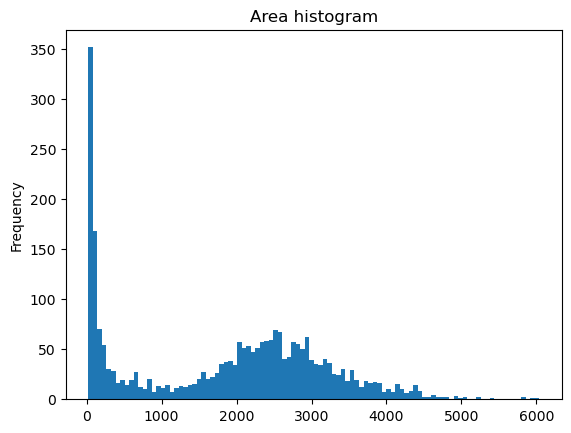

In [8]:
params_df = estimate_parameters_from_labels(stardist_labels, is_timelapse=True)
if in_notebook:
    params_df["area"].plot(kind="hist", bins=100, title="Area histogram")

## Optimize the tracking using optuna and ultrack

In [9]:
import optuna

In [10]:
config = MainConfig()
pprint(config.dict())

{
│   'data_config': {'n_workers': 1, 'working_dir': '.', 'database': 'sqlite', 'address': None},
│   'segmentation_config': {
│   │   'min_area': 100,
│   │   'max_area': 1000000,
│   │   'n_workers': 1,
│   │   'min_frontier': 0.0,
│   │   'threshold': 0.5,
│   │   'max_noise': 0.0,
│   │   'ws_hierarchy': 'area',
│   │   'anisotropy_penalization': 0.0
│   },
│   'linking_config': {
│   │   'max_distance': 15.0,
│   │   'n_workers': 1,
│   │   'max_neighbors': 5,
│   │   'distance_weight': 0.0,
│   │   'z_score_threshold': 5.0
│   },
│   'tracking_config': {
│   │   'solver_name': '',
│   │   'appear_weight': -0.001,
│   │   'disappear_weight': -0.001,
│   │   'division_weight': -0.001,
│   │   'n_threads': -1,
│   │   'window_size': None,
│   │   'overlap_size': 1,
│   │   'solution_gap': 0.001,
│   │   'time_limit': 36000,
│   │   'method': 0,
│   │   'link_function': 'power',
│   │   'power': 4,
│   │   'bias': -0.0,
│   │   'dismiss_weight_guess': None,
│   │   'include_weight_guess': None
│   }
}

In [11]:
# set up the optuna study
study = optuna.create_study(
    study_name="cell_tracking",
    storage=f"sqlite:///{results_output_dir}/stardist.db",
    load_if_exists=True,
    direction="minimize",
)


# set up the objective function
def objective(trial):
    # get the parameters

    min_area = trial.suggest_int("min_area", 10, 49)
    max_area = trial.suggest_int("max_area", 50, 100)
    threshold = trial.suggest_float("threshold", 0.1, 0.9)

    max_distance = trial.suggest_int("max_distance", 5, 50)
    max_neighbors = trial.suggest_int("max_neighbors", 1, 25)
    z_score_threshold = trial.suggest_float("z_score_threshold", 1, 10)

    appear_weight = trial.suggest_float("appear_weight", -0.1, 0)
    disappear_weight = trial.suggest_float("disappear_weight", -0.1, 0)
    division_weight = trial.suggest_float("division_weight", -0.1, 0)
    power = trial.suggest_int("power", 1, 10)
    bias = trial.suggest_float("bias", -0.1, 0)
    solution_gap = trial.suggest_float("solution_gap", 0.0001, 0.1)

    # set up the config
    config = MainConfig()
    config.segmentation_config.min_area = min_area
    config.segmentation_config.max_area = max_area
    config.segmentation_config.threshold = threshold

    config.linking_config.max_distance = max_distance
    config.linking_config.max_neighbors = max_neighbors
    config.linking_config.z_score_threshold = z_score_threshold

    config.tracking_config.appear_weight = appear_weight
    config.tracking_config.disappear_weight = disappear_weight
    config.tracking_config.division_weight = division_weight
    config.tracking_config.power = power
    config.tracking_config.bias = bias
    config.tracking_config.solution_gap = solution_gap
    config.solver_name = "CBC"
    try:
        track(
            foreground=detections,
            edges=edges,
            config=config,
            overwrite=True,
        )
    except ValueError as e:
        print(e)
        return 0
    # get the number of tracks
    tracks_df, graph = to_tracks_layer(config)
    number_of_tracks = tracks_df["track_id"].nunique()
    print(f"There {max_number_of_objects} expected tracks; found {number_of_tracks}")
    tracks_df.head()
    tracks_difference_from_psuedo_gt = np.abs(number_of_tracks - max_number_of_objects)
    return tracks_difference_from_psuedo_gt


# run the optimization
study.optimize(objective, n_trials=5)

[I 2025-01-06 13:37:54,490] Using an existing study with name 'cell_tracking' instead of creating a new one.
[W 2025-01-06 13:37:54,593] Trial 105 failed with parameters: {'min_area': 41, 'max_area': 57, 'threshold': 0.8944942153976325, 'max_distance': 7, 'max_neighbors': 9, 'z_score_threshold': 4.776100359363242, 'appear_weight': -0.02123051247920131, 'disappear_weight': -0.08531120042610559, 'division_weight': -0.06256952164927501, 'power': 7, 'bias': -0.07760436665033689, 'solution_gap': 0.09482918805317798} because of the following error: ValueError('"MainConfig" object has no field "solver_name"').
Traceback (most recent call last):
  File "/home/lippincm/miniforge3/envs/timelapse_segmentation_env/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_3117201/934972978.py", line 45, in objective
    config.solver_name = "CBC"
  File "/home/lippincm/miniforge3/envs/timelapse_segmentation_env/lib/pyth

ValueError: "MainConfig" object has no field "solver_name"

In [ ]:
# get the best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")
study.best_value

In [ ]:
# set up the config with the best parameters
config = MainConfig()
config.segmentation_config.min_area = best_params["min_area"]
config.segmentation_config.max_area = best_params["max_area"]
config.segmentation_config.threshold = best_params["threshold"]

config.linking_config.max_distance = best_params["max_distance"]
config.linking_config.max_neighbors = best_params["max_neighbors"]
config.linking_config.z_score_threshold = best_params["z_score_threshold"]

config.tracking_config.appear_weight = best_params["appear_weight"]
config.tracking_config.disappear_weight = best_params["disappear_weight"]
config.tracking_config.division_weight = best_params["division_weight"]
config.tracking_config.power = best_params["power"]
config.tracking_config.bias = best_params["bias"]
config.tracking_config.solution_gap = best_params["solution_gap"]
pprint(config.dict())
# write the config to a file for reference later
with open(f"{results_output_dir}/ultrack_config.json", "w") as f:
    f.write(config.json())

In [ ]:
track(
    foreground=detections,
    edges=edges,
    config=config,
    overwrite=True,
)

In [ ]:
tracks_df, graph = to_tracks_layer(config)
labels = tracks_to_zarr(config, tracks_df)
tracks_df.to_parquet(
    f"{results_output_dir}/{str(input_dir_main).split('MaxIP_')[1]}_tracks.parquet"
)
print(tracks_df["track_id"].nunique())
print(
    f"There {max_number_of_objects} expected tracks; found {tracks_df['track_id'].nunique()}"
)
tracks_df.head()

In [ ]:
# save the tracks as parquet
tracks_df.reset_index(drop=True, inplace=True)
tracks = np.zeros((len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16)
cum_tracks_df = tracks_df.copy()
timepoints = tracks_df["t"].unique()

# zero out the track_df
cum_tracks_df = cum_tracks_df.loc[cum_tracks_df["t"] == -1]

In [ ]:
if in_notebook:
    for frame_index, _ in enumerate(timelapse_raw):
        tmp_df = tracks_df.loc[tracks_df["t"] == frame_index]
        cum_tracks_df = pd.concat([cum_tracks_df, tmp_df])
        plt.figure(figsize=(6, 5))
        plt.subplot(2, 3, 1)
        # rescale tbe intensity of the raw image
        raw_image = timelapse_raw_visualize[frame_index, :, :]
        raw_image = raw_image * 4096
        plt.imshow(raw_image, cmap="gray")
        plt.title("Raw")
        plt.axis("off")

        plt.subplot(2, 3, 2)
        plt.imshow(stardist_labels[frame_index, :, :], cmap="gray")
        plt.title("Masks")
        plt.axis("off")

        plt.subplot(2, 3, 3)
        sns.lineplot(data=cum_tracks_df, x="x", y="y", hue="track_id", legend=False)
        plt.imshow(labels[frame_index, :, :], cmap="gray", alpha=0.5)
        plt.title(f"Frame {frame_index}")
        plt.axis("off")

        plt.subplot(2, 3, 4)
        edge_image = skimage.exposure.adjust_gamma(
            edges[frame_index, :, :], gamma=0.0001
        )
        # make the outline brighter
        edge_image = edge_image * 1000
        plt.imshow(edge_image, cmap="gray")
        plt.title("Edges")
        plt.axis("off")

        plt.subplot(2, 3, 5)
        plt.imshow(detections[frame_index, :, :], cmap="gray")
        plt.title("Detections")
        plt.axis("off")

        plt.subplot(2, 3, 6)
        sns.lineplot(data=cum_tracks_df, x="x", y="y", hue="track_id", legend=False)
        plt.imshow(detections[frame_index, :, :], cmap="gray", alpha=0.5)
        plt.title(f"Frame {frame_index}")
        plt.axis("off")

        plt.tight_layout()
        plt.savefig(f"{temporary_output_dir}/tracks_{frame_index}.png")
    if in_notebook:
        plt.show()

In [ ]:
# load each image
files = [f for f in temporary_output_dir.glob("*.png")]
files = sorted(files, key=lambda x: int(x.stem.split("_")[1]))
frames = [Image.open(f) for f in files]
fig_path = figures_output_dir / f"{str(input_dir_main).split('MaxIP_')[1]}_tracks.gif"
# plot the line of each track in matplotlib over a gif
# get the tracks
# save the frames as a gif
frames[0].save(fig_path, save_all=True, append_images=frames[1:], duration=3, loop=0)

In [ ]:
# clean up tracking files
# remvoe temporary_output_dir
shutil.rmtree(temporary_output_dir)

track_db_path = pathlib.Path("data.db").resolve()
metadata_toml_path = pathlib.Path("metadata.toml").resolve()
if track_db_path.exists():
    track_db_path.unlink()
if metadata_toml_path.exists():
    metadata_toml_path.unlink()

In [ ]:
clear_gpu_memory()